In [1]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm

from utils import *

import matplotlib as mpl
import pandas as pd

# Set the default font and size
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 16

In [2]:
# temporarily do it for no lags
R = 4
N = R
# based on what index we choose in ecol_adv_lags:
rho_list = np.linspace(0, 0.4, 51)
rho = rho_list[34]
# Do it with D=1000
logD = log(1000)
gC = 1.0
N_community = 10000

all_stabilities = []
for n_diaux in range(R+1):
    community = {}
    stabilities = []
    for i in tqdm(range(N_community)):
        g_enz = generate_g(N, R)
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref = np.array([[1, 2, 3, 4], [2, 3, 4, 1], [3, 4, 1, 2], [4, 1, 2, 3]])
        col = np.argmax(g_enz, axis=1) # find column in g where it's the largest
        for row_i, row in enumerate(pref):
            index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
            row[0], row[index] = row[index], row[0]
        dep_orders = np.array(permutations)
        N_dep_order = len(dep_orders)
        rhos = rho * np.ones(N)

        community["g"] = g_enz
        community["rho"] = rhos
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []

        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G1 = G_mat_diaux_hwa(g_enz, gC, pref, dep_order, rhos)
            G2 = G_mat_cout_hwa(g_enz, gC, dep_order, rhos)
            G = np.vstack([G1[:n_diaux, :], G2[n_diaux:, :]])
            if(np.linalg.matrix_rank(G)>=N):
                t = np.linalg.inv(G)@np.ones(R)*logD
                if(sum(t>0) >= len(t)):
                    F1 = F_mat_diaux_hwa(g_enz, gC, pref, t, dep_order, logD, rhos)
                    F2 = F_mat_cout_hwa(g_enz, G2, t, dep_order, logD)
                    F = np.hstack([F1[:, :n_diaux], F2[:, n_diaux:]])
                    # print(F1, G1, np.linalg.det(F))
                    community["possible_orders"].append(dep_order)
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
    all_stabilities.append(stabilities)
pickle.dump(all_stabilities, open(f"../data/structural_stability/orig.pkl", "wb"))

100%|██████████| 10000/10000 [00:50<00:00, 199.41it/s]


In [3]:
def generate_intermediate_colors(hex_color1, hex_color2, num_colors):
    # Convert hex codes to RGB format
    color1_rgb = tuple(int(hex_color1[i:i+2], 16) for i in (1, 3, 5))
    color2_rgb = tuple(int(hex_color2[i:i+2], 16) for i in (1, 3, 5))
    
    # Calculate the step size for each color component
    step_r = (color2_rgb[0] - color1_rgb[0]) / (num_colors + 1)
    step_g = (color2_rgb[1] - color1_rgb[1]) / (num_colors + 1)
    step_b = (color2_rgb[2] - color1_rgb[2]) / (num_colors + 1)
    
    # Generate intermediate colors
    intermediate_colors = [hex_color1]
    for i in range(1, num_colors + 1):
        r = int(color1_rgb[0] + step_r * i)
        g = int(color1_rgb[1] + step_g * i)
        b = int(color1_rgb[2] + step_b * i)
        intermediate_colors.append('#{:02x}{:02x}{:02x}'.format(r, g, b))
    intermediate_colors.append(hex_color2)
    
    return intermediate_colors

c:\Users\wzh41\anaconda3\envs\sci-comp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\wzh41\anaconda3\envs\sci-comp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\wzh41\anaconda3\envs\sci-comp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\wzh41\anaconda3\envs\sci-comp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\wzh41\anaconda3\envs\sci-comp\lib\site-packages\seabo

Text(0.5, -5.2500000000000036, 'Normalized structural stability')

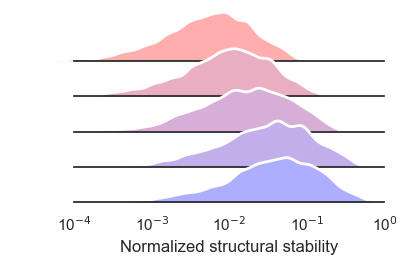

In [4]:
import seaborn as sns
# plt.rcParams["figure.figsize"] = (6, 4)
# n_cut = min([len(i) for i in all_stabilities])
# for stabilities in all_stabilities:
#     sns.kdeplot(stabilities[:n_cut], alpha = 0.2, fill=True)
# plt.xlim(-4, 0)
# plt.show()

# plt.rcParams["figure.figsize"] = (6, 4)
# colors = generate_intermediate_colors("#ffaeae", "#aeaeff", 3)
# data = {"n_diaux":sum([[i for j in stabilities][:n_cut] for i, stabilities in enumerate(all_stabilities)], []), 
#         "stability":sum([i[:n_cut] for i in all_stabilities], [])}
# sns.violinplot(x="n_diaux", y="stability", data=data, palette=colors, alpha=0.4)
# plt.ylim(-4.5, 0.3)
# plt.yticks(np.arange(0, -5, -1), ["10$^{"+str(i)+"}$" for i in np.arange(0, -5, -1)])
# plt.ylabel("Structural stability")
# plt.xlabel("Sequential species in community")
# # plt.yscale("log")
# plt.savefig("../figures/struc_stability.pdf")
# plt.show()

n_cut = min([len(i) for i in all_stabilities])
plt.rcParams["figure.figsize"] = (6, 4)
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
colors = generate_intermediate_colors("#ffaeae", "#aeaeff", 3)
palette = sns.color_palette(colors, 5)
# data = {"n_diaux":sum([[i for j in stabilities][:n_cut] for i, stabilities in enumerate(all_stabilities)], []), 
#         "stability":sum([i[:n_cut] for i in all_stabilities], [])}
data = {"n_diaux":sum([[i for j in stabilities] for i, stabilities in enumerate(all_stabilities)], []), 
        "stability":sum([i for i in all_stabilities], [])}
data = pd.DataFrame(dict(n_diaux=data["n_diaux"], stability=data["stability"]))
grid = sns.FacetGrid(data, row="n_diaux", hue="n_diaux", aspect=8, height=0.5, palette=palette)
grid.map(sns.kdeplot, "stability", bw_adjust=.6, clip_on=False, fill=True, lw=0, alpha=1)
grid.map(sns.kdeplot, "stability", clip_on=False, color="w", lw=2, bw_adjust=.6)
grid.figure.subplots_adjust(hspace=-.3)
grid.set_titles("")
grid.set(yticks=[], ylabel="")
grid.despine(left=True)
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, ha="left", va="center", transform=ax.transAxes)
#     ax.text(1, .2, R-int(label), ha="right", va="center", transform=ax.transAxes)
# grid.map(label, "n_diaux")
plt.xticks(np.arange(0, -5, -1), ["10$^{"+str(i)+"}$" for i in np.arange(0, -5, -1)])
plt.xlim(-4, 0)
plt.xlabel("Normalized structural stability")
# plt.savefig("../figures/struc_stability_ridges.pdf", bbox_inches="tight")
# plt.show()

In [5]:
# for different parameters:
# temporarily do it for no lags
R = 4
N = R
# based on what index we choose in ecol_adv_lags:
rho_list = np.linspace(0, 0.4, 51)
rho = rho_list[34]
# Do it with D=1000
gC = 1.0
N_community = 10000

params = [[100, 0.1], [1000, 0.1], [10000, 0.1], [1000, 0.075], [1000, 0.1], [1000, 0.2]]

for param in params:
    logD = log(param[0])
    gsigma = param[1]
    all_stabilities = []
    for n_diaux in range(R+1):
        community = {}
        stabilities = []
        for i in tqdm(range(N_community)):
            g_enz = generate_g(N, R, gC, gsigma)
            permutations = list(itertools.permutations(list(range(1, R+1))))
            pref = np.array(random.choices(permutations, k=N))
            col = np.argmax(g_enz, axis=1) # find column in g where it's the largest
            for row_i, row in enumerate(pref):
                index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
                row[0], row[index] = row[index], row[0]
            dep_orders = np.array(permutations)
            N_dep_order = len(dep_orders)
            rhos = rho * np.ones(N)

            community["g"] = g_enz
            community["rho"] = rhos
            community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
            community["allowed_orders"] = dep_orders
            community["possible_orders"] = []

            for j in range(N_dep_order):
                dep_order = dep_orders[j]
                G1 = G_mat_diaux_hwa(g_enz, gC, pref, dep_order, rhos)
                G2 = G_mat_cout_hwa(g_enz, gC, dep_order, rhos)
                G = np.vstack([G1[:n_diaux, :], G2[n_diaux:, :]])
                if(np.linalg.matrix_rank(G)>=N):
                    t = np.linalg.inv(G)@np.ones(R)*logD
                    if(sum(t>0) >= len(t)):
                        F1 = F_mat_diaux_hwa(g_enz, gC, pref, t, dep_order, logD, rhos)
                        F2 = F_mat_cout_hwa(g_enz, G2, t, dep_order, logD)
                        F = np.hstack([F1[:, :n_diaux], F2[:, n_diaux:]])
                        # print(F1, G1, np.linalg.det(F))
                        community["possible_orders"].append(dep_order)
                        stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
        all_stabilities.append(stabilities)
    pickle.dump(all_stabilities, open(f"../data/structural_stability/ss_D={param[0]}_gsigma={param[1]}.pkl", "wb"))

100%|██████████| 10000/10000 [00:48<00:00, 205.64it/s]


C:\Users\wzh41\AppData\Local\Temp\ipykernel_772\1618940499.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([5, 4, 3, 2, 1, 0])


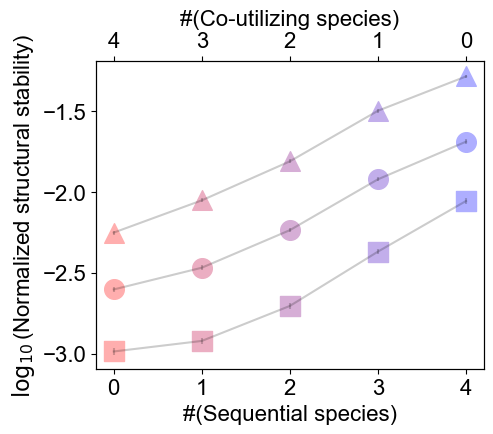

C:\Users\wzh41\AppData\Local\Temp\ipykernel_772\1618940499.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([5, 4, 3, 2, 1, 0])


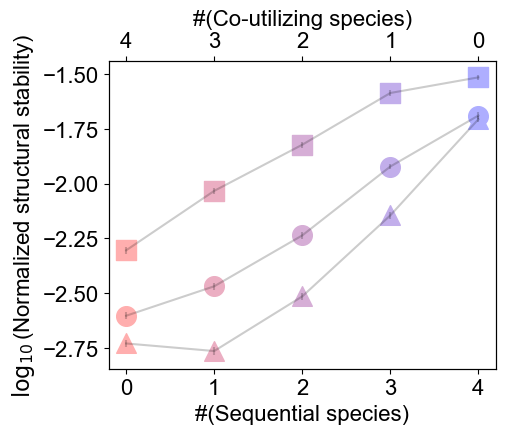

In [3]:
import matplotlib.colors as mcolors
def interpolate_colors(color1, color2, k):
    """Generate a list of colors interpolating between two hex colors."""
    rgb1 = mcolors.hex2color(color1)
    rgb2 = mcolors.hex2color(color2)
    # Interpolate colors
    interpolated_colors = [
        mcolors.to_hex([(1 - t) * c1 + t * c2 for c1, c2 in zip(rgb1, rgb2)])
        for t in [i / (k - 1) for i in range(k)]
    ]
    return interpolated_colors

plt.rcParams["figure.figsize"] = (5,4)
fig, ax1 = plt.subplots()
params = [[100, 0.1], [1000, 0.1], [10000, 0.1]]
marker_list = ["^", "o", "s"]
colors = interpolate_colors("#ffaeae", "#aeaeff", 5)
for p_idx, param in enumerate(params):
    all_stabilities = pickle.load(open(f"../data/structural_stability/ss_D={param[0]}_gsigma={param[1]}.pkl", "rb"))
    ax1.errorbar(range(5), [np.mean(i) for i in all_stabilities], yerr=[np.std(i)/sqrt(len(i)) for i in all_stabilities], color="k", alpha=0.2)
    for idx, i in enumerate(all_stabilities):
        ax1.scatter([idx], np.mean(i), color=colors[idx], marker=marker_list[p_idx], s=200)
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_xlabel("#(Sequential species)")
ax1.set_ylabel("$\log_{10}$"+"(Normalized structural stability)")
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("#(Co-utilizing species)")
ax2.set_xticklabels([5, 4, 3, 2, 1, 0])
plt.savefig("../figures/struc_stability_D.pdf", bbox_inches="tight")
plt.show()


fig, ax1 = plt.subplots()
params = [[1000, 0.075], [1000, 0.1], [1000, 0.2]]
marker_list = ["^", "o", "s"]
colors = interpolate_colors("#ffaeae", "#aeaeff", 5)
for p_idx, param in enumerate(params):
    all_stabilities = pickle.load(open(f"../data/structural_stability/ss_D={param[0]}_gsigma={param[1]}.pkl", "rb"))
    ax1.errorbar(range(5), [np.mean(i) for i in all_stabilities], yerr=[np.std(i)/sqrt(len(i)) for i in all_stabilities], color="k", alpha=0.2)
    for idx, i in enumerate(all_stabilities):
        ax1.scatter([idx], np.mean(i), color=colors[idx], marker=marker_list[p_idx], s=200)
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_xlabel("#(Sequential species)")
ax1.set_ylabel("$\log_{10}$"+"(Normalized structural stability)")
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("#(Co-utilizing species)")
ax2.set_xticklabels([5, 4, 3, 2, 1, 0])
# plt.savefig("../figures/struc_stability_sigma.pdf", bbox_inches="tight")

In [3]:
# what resource is the species eating
def resource_eating(pref_list, dep_order):
    N, R = pref_list.shape[0], pref_list.shape[1]
    RE = np.zeros([N, R], dtype=np.int32)
    for i_n in range(N):
        for i_t in range(R):
            for i in range(R):
                top_resource = pref_list[i_n][i]
                if(top_resource in dep_order[i_t:]):
                    RE[i_n, i_t] = top_resource
                    break
    return RE

#def a state matrix
def niche_growth_state(RE, taus, t_order):
    N, R = taus.shape[0], taus.shape[1]
    # here we define a niche growth state matrix S, whose elements can be 0, 1, or 2
    # 0 means no growth; 1 means growth during full niche; 2 means part of of niche is taken by lag
    # and define a tau_mod - the lag time in each niche for those 2 elements in S. 
    S = np.ones([N, R])
    tau_mod = np.zeros([N, R])
    for species in range(N):
        # check the behavior between rsi-th t-niche and rei-th t-niche
        # which starts from 1 (second t-niche),
        # because we assume sum(t-niche)<<T, which means the lag in first t-niche is due to recovering from dormancy,
        # and we assume them to be species- and resource- independent. 
        res_last = 0 
        in_lagphase = 0
        tau_new = 0
        for niche in np.arange(1, R):
            # if next time niche is a different resource, 
            # we assume the species would renew the current lag by the lagtime of
            # switching from the previous (actively consuming) nutrient to the current nutrient
            # regardless of whether it was already in the middle of a lag phase or not. 
            if(RE[species][niche]!=RE[species][niche-1]): 
                tau_new = taus[species, RE[species][res_last]-1, RE[species][niche]-1]
                if(tau_new < t_order[niche]):
                    S[species, niche] = 2
                    tau_mod[species, niche] = tau_new
                    res_last = niche
                    in_lagphase = 0
                else:
                    S[species, niche] = 0
                    tau_new -= max(0, t_order[niche])
                    in_lagphase = 1
            # if the next time niche is a same resource, 
            # when the species has not yet finished a lag, it would continue being in that lag
            # with no need to renew the lagtime value. 
            elif(in_lagphase == 1):
                if(tau_new < t_order[niche]):
                    S[species, niche] = 2
                    tau_mod[species, niche] = tau_new
                    in_lagphase = 0
                    res_last = niche
                else:
                    S[species, niche] = 0
                    tau_new -= max(0, t_order[niche])
    return S, tau_mod

# this gives the first iteration of the tau_mod
def tau_gtoG(taus, pref, dep_order):
    N, R = taus.shape[0], taus.shape[1]
    tau_G = np.zeros([N, R])
    for i_n in range(N):
        top_resource_prev = -1
        for i_t in range(R):
            for i in range(R):
                top_resource = pref[i_n][i]
                if(top_resource in dep_order[i_t:]):
                    break
            if(i_t>=1):
                tau_G[i_n, i_t] = taus[i_n, top_resource_prev-1, top_resource-1]
            top_resource_prev = top_resource
    return tau_G

# define a function to do the iterative thing
def tsolve_iter(G, RE, taus, tau_mod, logD):
    # species-niche growth state S
    N, R = taus.shape[0], taus.shape[1]
    S = np.ones([N, R])
    # make the modifications in the first iteration
    converged = 0
    t_iter_compare = np.zeros(R)
    for count in range(10):
        rhs = logD + np.diag( (G*(S>0)) @np.transpose(tau_mod))
        if(np.linalg.matrix_rank(G*(S>0))>=N):
            t_iter = np.linalg.inv(G*(S>0))@rhs
            S, tau_mod = niche_growth_state(RE, taus, t_iter)
            if ((t_iter_compare==t_iter).all() and np.sum(t_iter)<=24):
                converged = 1
                break
            t_iter_compare = t_iter
        else:
            converged = 0
            break
    return converged, t_iter_compare, S, tau_mod

def F_mat_lag(g, gC, pref_list, dep_order, rho, logD, N, R, taus):
    RE = resource_eating(pref_list, dep_order)
    tau_mod = tau_gtoG(taus, pref_list, dep_order)
    G = G_mat_diaux_hwa(g, gC, pref_list, dep_order, rho)
    _, t_iter, S, tau_mod = tsolve_iter(G, RE, taus, tau_mod, logD)
    F_mat = np.zeros([R, N])
    G_mod = G*(S>0)
    for species in range(N):
        current_growth = G_mod[species][0]*(t_iter[0]-tau_mod[species][0])
        coeff = 1
        for niche in range(1, R):
            if(RE[species, niche-1]!=RE[species, niche]):
                F_mat[species, RE[species, niche-1]-1] = coeff * (exp(current_growth) - 1)
                coeff *= exp(current_growth)
                current_growth = G_mod[species][niche]*(t_iter[niche]-tau_mod[species][niche])
            else:
                current_growth += G_mod[species][niche]*(t_iter[niche]-tau_mod[species][niche])
            if(niche==R-1):
                F_mat[species, RE[species, niche]-1] = coeff * (exp(current_growth) - 1)
    return np.transpose(F_mat)

In [18]:
R = 4
N = R
# based on what index we choose in ecol_adv_lags:
rho_list = np.linspace(0, 0.4, 51)
rho = rho_list[34]
# Do it with D=1000
gC = 1.0
N_community = 10000
tau0 = 0.04
MIN_RHO = 1e-200
logD = log(1000)
gsigma = 0.1
all_stabilities = []
taulist = [0, 0.04, 0.4]

community = {}
for tau0 in taulist:
    taus = np.array([tau0*log((1-3*rho/4)/max(rho/4, MIN_RHO))*(np.ones([R, R])-np.eye(R)) for idx in range(N)]) * np.random.uniform(0.98, 1.02, size=(N, R, R))
    stabilities = []
    for i in tqdm(range(N_community)):
        g_enz = generate_g(N, R, gC, gsigma)
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref = np.array(random.choices(permutations, k=N))
        col = np.argmax(g_enz, axis=1) # find column in g where it's the largest
        for row_i, row in enumerate(pref):
            index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
            row[0], row[index] = row[index], row[0]
        dep_orders = np.array(permutations)
        N_dep_order = len(dep_orders)
        rhos = rho * np.ones(N)

        community["g"] = g_enz
        community["rho"] = rhos
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []

        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            RE = resource_eating(pref, dep_order)
            G = G_mat_diaux_hwa(g_enz, gC, pref, dep_order, rhos)
            if(np.linalg.matrix_rank(G)>=N):
                tau_mod = tau_gtoG(taus, pref, dep_order)
                converged, t_iter, S, tau_mod = tsolve_iter(G, RE, taus, tau_mod, logD)
                if(converged == 1 and sum(t_iter>0) >= len(t_iter)):
                    community["possible_orders"].append(dep_order)
                    F = F_mat_lag(g_enz, gC, pref, dep_order, rho*np.ones(N), logD, N, R, taus)
                    if(abs(np.linalg.det(F))>1e-10):
                        stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
    all_stabilities.append(stabilities)
# pickle.dump(all_stabilities, open(f"../data/structural_stability/ss_D={param[0]}_tau={tau0}.pkl", "wb"))

100%|██████████| 10000/10000 [01:32<00:00, 107.95it/s]


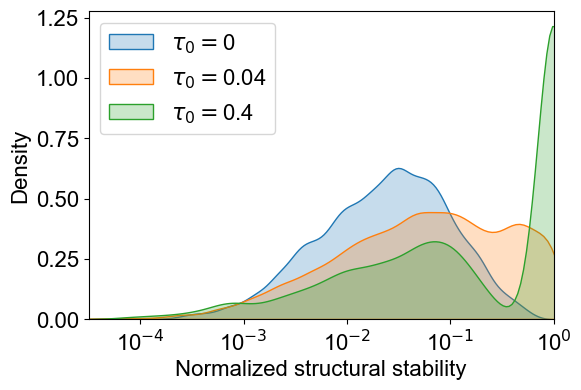

In [36]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (6,4)
for idx, data in enumerate(all_stabilities[:3]):
    # sns.histplot(data, kde=True, bins=50, edgecolor='black')
    sns.kdeplot(data, fill=True, bw_adjust=0.7, label="$\\tau_0=$"+str(taulist[idx]))

plt.xlim(-4.5, 0)
plt.xticks(np.arange(0, -5, -1), ["10$^{"+str(i)+"}$" for i in np.arange(0, -5, -1)])
plt.xlabel("Normalized structural stability")
plt.legend(loc="upper left")
plt.savefig("../figures/struc_stab_lag.pdf", bbox_inches="tight")

In [38]:
rho_list[34]/4

0.068